In [1]:
from typing import List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.special import softmax

from src.metrics import brier_score
from src.metrics import adaptive_calibration_error

In [2]:
list_of_all_models = [
    "gemma-2b.jsonl", "gemma-7b.jsonl",
    "gpt2.jsonl", "gpt2-medium.jsonl", "gpt2-large.jsonl", "gpt2-xl.jsonl",
    "opt-125m.jsonl", "opt-350m.jsonl", "opt-1.3b.jsonl", "opt-6.7b.jsonl"
]

In [3]:
def get_model_results(list_of_models: List[str], reduction_strategy: str = "sum") -> pd.DataFrame:
    
    results = []
    for m in list_of_models:
        r = pd.read_json(
            f"../results/FACTOR/{reduction_strategy}/{m}",
            orient="records",
            lines=True
        )
        r["model"] = m.removesuffix(".jsonl")
        r["softmax_scores"] = r["scores"].apply(lambda s: softmax(-1 * np.array(s)))
        r["predicted_answer"] = r["softmax_scores"].apply(np.argmax)
        r["correctly_predicted"] = r["predicted_answer"] == 0
        r["base_conf"] = r.apply(lambda x: np.max(x["softmax_scores"]), axis=1)
        r["margin_conf"] = r["softmax_scores"].apply(lambda s: np.max(s) - np.partition(s, -2)[-2])
    
        results.append(r)
    return pd.concat(results, ignore_index=True)

## Obtain Scores for Mean & Sum Reduction

In [4]:
factor_sum = get_model_results(list_of_all_models)
factor_mean = get_model_results(list_of_all_models, reduction_strategy="mean")

## Comparison Accuracies Mean vs. Sum Reduction

In [5]:
accuracy_results = {
    "model": [],
    "mean": [],
    "sum": []
}
for model in list_of_all_models:
    model = model.removesuffix(".jsonl")
    accuracy_results["model"].append(model)
    d_mean = factor_mean.query("model == @model")
    d_sum = factor_sum.query("model == @model")
    acc_mean = d_mean["correctly_predicted"].mean()
    acc_sum = d_sum["correctly_predicted"].mean()
    accuracy_results["mean"].append(acc_mean*100)
    accuracy_results["sum"].append(acc_sum*100)

pd.DataFrame(accuracy_results).round(2).to_latex(
    "tables/accuracies_factor.txt",
    index=False,
    float_format="%.2f",
    formatters={
            "model": lambda x: r"\texttt{" + str(x) + "}"
        },
    escape=False,
)

In [6]:
ace_results = {
    "model": [],
    "accuracy": [],
    "ace_base": [],
    "ace_margin": []
}

for model in list_of_all_models:
    model = model.removesuffix(".jsonl")
    d = factor_sum.query("model == @model")
    accuracy = d["correctly_predicted"].mean()
    ace_base = adaptive_calibration_error(d["correctly_predicted"], d["base_conf"])
    ace_margin = adaptive_calibration_error(d["correctly_predicted"], d["margin_conf"])
    
    ace_results["model"].append(model)
    ace_results["accuracy"].append(round(accuracy*100, 2))  
    ace_results["ace_base"].append(round(ace_base, 3))
    ace_results["ace_margin"].append(round(ace_margin, 3))

ace_df = pd.DataFrame(ace_results)

In [7]:
print(ace_df["ace_base"].mean(),
      ace_df["ace_margin"].mean())

0.4755000000000001 0.4457


In [8]:
(
    ace_df
    .round(3)
    .to_latex(
        "../tables/metrics_factor.txt",
        index=False,
        float_format="%.3f",
        formatters={
            "model": lambda x: r"\texttt{" + str(x) + "}"
        },
        escape=False,
    )
)

In [9]:
bs_results = {
    "model": [],
    "accuracy": [],
    "bs_base": [],
    "bs_margin": []
}

for model in list_of_all_models:
    model = model.removesuffix(".jsonl")
    d = factor_sum.query("model == @model")
    accuracy = d["correctly_predicted"].mean()
    bs_base = brier_score(d["correctly_predicted"], d["base_conf"])
    bs_margin = brier_score(d["correctly_predicted"], d["margin_conf"])
    
    bs_results["model"].append(model)
    bs_results["accuracy"].append(round(accuracy*100, 2))  
    bs_results["bs_base"].append(round(bs_base, 3))
    bs_results["bs_margin"].append(round(bs_margin, 3))

bs_df = pd.DataFrame(bs_results)

In [10]:
(
    bs_df
    .round(3)
    .to_latex(
        "../tables/brier_scores_factor.txt",
        index=False,
        float_format="%.3f",
        formatters={
            "model": lambda x: r"\texttt{" + str(x) + "}"
        },
        escape=False,
    )
)

## Get data for BEAR to compare

In [11]:
bear_data = pd.read_json("../results/FACTOR/bear_sampled_data.json", orient="records", lines=True).query("sample_size == 5")

In [12]:
bear_data["accuracy"] = round(bear_data["accuracy"]*100, 2)
bear_data = bear_data[~bear_data["model"].isin([
    "bert-base-cased", "bert-large-cased",
    "roberta-base", "roberta-large",
    "xlm-roberta-base", "xlm-roberta-large"
])]

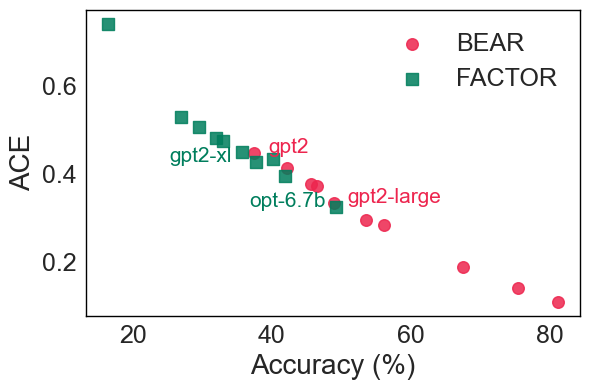

In [13]:
fig, ax = plt.subplots(figsize=(6, 4))

# BEAR
ax.scatter(
    bear_data["accuracy"],
    bear_data["ace"],
    label="BEAR",
    marker="o",
    s=70,
    alpha=0.85,
    color="#ed254e"
)

# FACTOR
ax.scatter(
    ace_df["accuracy"],
    ace_df["ace_base"],
    label="FACTOR",
    marker="s",
    s=70,
    alpha=0.85,
    color="#007e5d"
)

for _, row in bear_data.iterrows():
    if row["model"] in ["gpt2", "gpt2-large"]:
        ax.text(
            row["accuracy"]+2,
            row["ace"],
            row["model"],
            fontsize=15,
            color="#ed254e"
        )

for _, row in ace_df.iterrows():
    if row["model"] in ["gpt2-xl", "opt-6.7b"]:
        ax.text(
            row["accuracy"]-12.5,
            row["ace_base"],
            row["model"],
            fontsize=15,
            color="#007e5d"
        )

# Axes and styling
ax.set_xlabel("Accuracy (%)", fontsize=20)
ax.set_ylabel("ACE", fontsize=20)
ax.tick_params(axis="both", which="major", labelsize=18)
ax.grid(False)
ax.set_facecolor("white")
for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(1.0)
        spine.set_color("black")
ax.legend(frameon=False, fontsize=18)

plt.tight_layout()
plt.savefig("../images/pdf/ace_vs_accuracy_factor_bear.pdf", format="pdf")
plt.show()

In [14]:
ace_df.ace_margin.mean()

np.float64(0.4457)

In [15]:
bear_data.ace.mean() - bear_data.ace_margin.mean()

np.float64(0.06819283066000001)

In [16]:
ace_df.ace_base.mean() - ace_df.ace_margin.mean()

np.float64(0.029800000000000104)

In [17]:
print(factor_sum.loc[0, "completion"])

The Hungarian Socialist Party suffered a heavy defeat in the 2010 election (won by Fidesz with a ⅔ majority), gaining only 19,3% of the votes, and 59 seats in the parliament.


In [18]:
print(factor_sum.loc[0, "contradictions"])

['The Hungarian Socialist Party suffered a heavy defeat in the 2010 election (won by Jobbik with a ⅔ majority), gaining only 19,3% of the votes, and 59 seats in the parliament.', 'The Hungarian Socialist Party achieved a heavy victory in the 2010 election (won by Fidesz with a ⅔ majority), gaining only 19,3% of the votes, and 59 seats in the parliament.', 'The Hungarian Socialist Party suffered a heavy defeat in the 2010 election (won by Fidesz with a ⅔ majority), gaining only 32,3% of the votes, and 59 seats in the parliament.']


In [19]:
print(factor_sum.loc[0, "softmax_scores"]*100)

[7.69094587e+01 7.11308697e-02 2.77768832e-06 2.30194076e+01]


In [20]:
factor_sum.head()

,full_prefix,completion,contradictions,scores,model,softmax_scores,predicted_answer,correctly_predicted,base_conf,margin_conf
0,of Hungary.\n\nAt a party congress on 7 Octob...,The Hungarian Socialist Party suffered a heavy...,[The Hungarian Socialist Party suffered a heav...,"[89.6870040894, 96.6728668213, 106.8235244751,...",gemma-2b,"[0.7690945871513366, 0.0007113086974605549, 2....",0,True,0.769095,0.538901
1,"Haagerup property\n\nIn mathematics, the Haage...","has the Haagerup approximation property, also ...","[has the Haagerup approximation property, also...","[162.7056121826, 173.6158447266, 162.904861450...",gemma-2b,"[0.5496426469256638, 1.0042148337159797e-05, 0...",0,True,0.549643,0.099295
2,"Ariel S. Ballif\n\nAriel Smith Ballif, Sr. (De...",He also served as president of the New Zealand...,[He also served as president of the New Zealan...,"[69.831741333, 68.7632598877, 78.0469741821, 7...",gemma-2b,"[0.2554694329684833, 0.7436602011758446, 6.910...",1,False,0.743660,0.488191
3,Americo Sbigoli\n\nAmerico (Amerigo) Sbigoli (...,"While tragic in and of itself, this incident a...","[While tragic in and of itself, this incident ...","[215.6825714111, 216.9169006348, 211.559631347...",gemma-2b,"[0.011037910513831186, 0.0032123621351901866, ...",2,False,0.681486,0.377222
4,Athletic Grounds\n\nThe Athletic Grounds () is...,The stadium was known from May 2011 as the Mor...,[The stadium was known from May 2011 as the Mo...,"[131.6678314209, 130.6958770752, 140.305206298...",gemma-2b,"[0.2740927718446996, 0.7244559636170665, 4.861...",1,False,0.724456,0.450363
